# Capstone 2 Modeling (hour)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [11]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import BATS, TBATS
from IPython.display import Image
%matplotlib inline

In [12]:
# load the csv files in data/processed folder
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
# change indexes to time series
dfts.index = pd.to_datetime(dfts.index)
# dfts doesn't have 24 hours, so we will reindex it and fill in the missing hours with 0
dfts24 = dfts.reindex(pd.date_range('2016-01-04', periods=17472, freq='h'), fill_value=0)
display(dfts24.info())
display(dfts24.head(3))
display(dfts24.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17472 entries, 2016-01-04 00:00:00 to 2017-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   17472 non-null  float64
dtypes: float64(1)
memory usage: 273.0 KB


None

,sales
2016-01-04 00:00:00,0.0
2016-01-04 01:00:00,0.0
2016-01-04 02:00:00,0.0


,sales
2017-12-31 21:00:00,86.495385
2017-12-31 22:00:00,61.535769
2017-12-31 23:00:00,0.000000


In [13]:
# mkae a hourly time series dataframe for 2016 and 2017
dfts2016 = dfts24.iloc[:8736]
dfts2017 = dfts24.iloc[8736:]
display(dfts2016.head(1))
display(dfts2016.tail(1))
display(dfts2017.head(1))
display(dfts2017.tail(1))

,sales
2016-01-04,0.0


,sales
2017-01-01 23:00:00,0.0


,sales
2017-01-02,0.0


,sales
2017-12-31 23:00:00,0.0


In [14]:
# make a baseline dataframe that consist of date rane 2018-01-01 (Mon) and onward of next 8736 hours (364 days)
# with sales values that's average of 2016 and 2017

# make a dataframe with 2016 and 2017's info
bl_df = pd.concat([dfts2016.sales.reset_index(), dfts2017.sales.reset_index()], axis=1, ignore_index=True)
bl_df.columns=['2016', 'sales2016', '2017', 'sales2017']
# define an avg function to get the avg of 2 inputs, then we can use it to df.apply lambda and get the baseline
def avg(one, two):
    return (one + two)/2
# get the baseline values that's the average of 2016 and 2017
bl_df['baseline'] = bl_df.apply(lambda x: avg(x['sales2016'], x['sales2017']), axis=1)
#set index to date ranging from 2018-01-01 until 8736 hours later
bl_df.index = pd.date_range('2018-01-01', periods=8736, freq='H')
#remove unnecessary columns; just keep the baseline column
bl_df = bl_df.baseline
# save the dataframe to csv file for easier access
bl_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\hourly_baseline.csv',
                      index=True)
bl_df

2018-01-01 00:00:00      0.000000
2018-01-01 01:00:00      0.000000
2018-01-01 02:00:00      0.000000
2018-01-01 03:00:00      0.000000
2018-01-01 04:00:00      0.000000
                          ...    
2018-12-30 19:00:00     52.335000
2018-12-30 20:00:00     76.536731
2018-12-30 21:00:00    101.972692
2018-12-30 22:00:00     75.392885
2018-12-30 23:00:00      0.000000
Freq: H, Name: baseline, Length: 8736, dtype: float64

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

We will use 10/1/2017 until end of 2017 as testing data, while forecasting until end of 2018-12-29 to compare with the baseline.

In [15]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04 00','2017-09-30 23'
test_start,test_end = '2017-10-01 00','2017-12-31 23'
train = dfts24['sales'][train_start:train_end].dropna()
test = dfts24['sales'][test_start:test_end].dropna()
baseline = bl_df

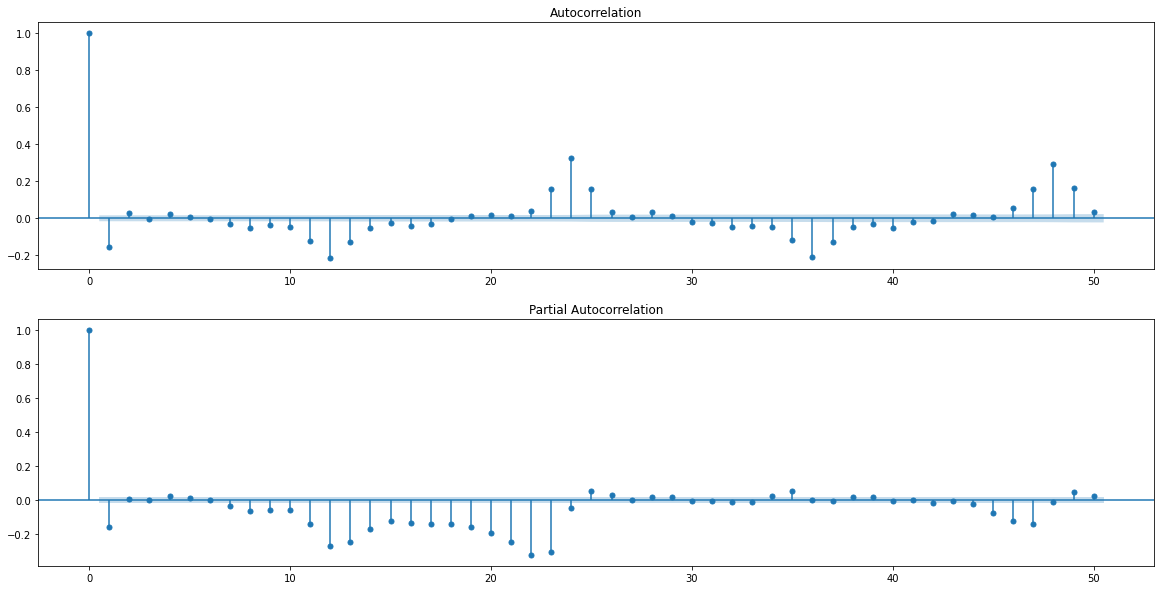

In [16]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 24 periods, indicating a daily pattern exists, and from previous modeling (day) we already know that there's also a strong weekly pattern, which makes it 24*7=168.

In [17]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

# TBATS
From modeling the daily sales data, TBATS was able to capture both weekly and yearly seaonsality, let's give it a try and see if it's able to capture 3 seasonalities.

In [8]:
# Fit the model, seasonal_periods=(24, 24*7=168, 24*364=8736) daily, weekly, and yearly
tbats = TBATS(seasonal_periods=(24, 168, 8736)).fit(train)

In [9]:
# forecasts
pred = tbats.forecast(steps=(len(test)))
forecast = tbats.forecast(steps=(len(test)+8736))
fore=forecast[len(test):]

In [10]:
#create a dataframe to record and save the scores as csv
TBATS_score = pd.DataFrame({
    'model':'TBATS-hourly',
    'MSE':mean_squared_error(test,pred),
    'MAE':mean_absolute_error(test,pred),
    'AIC':tbats.aic,
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore)}, index=[0])
TBATS_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_score.csv',
                index=False)
TBATS_score

,model,MSE,MAE,AIC,ForeMSE,ForeMAE
0,TBATS-hourly,946.67262,22.8054,246208.405574,590.293342,19.192608


In [15]:
# create a df to store the pred/forecast
TBATS_pred = pd.DataFrame({
    'pred':pred,
})
TBATS_pred.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred.csv',
                index=False)
TBATS_fore = pd.DataFrame({
    'fore':fore,
})
TBATS_fore.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_fore.csv',
                  index=False)

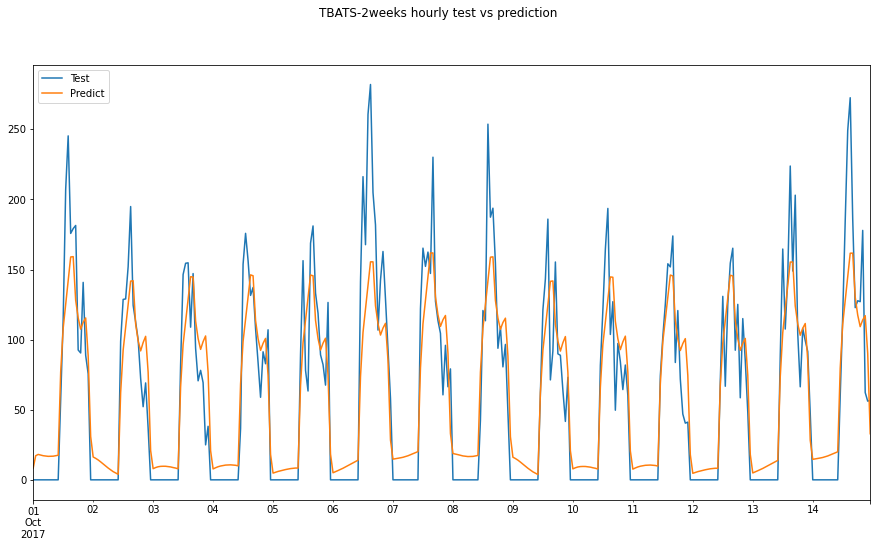

In [16]:
#view the plot of test vs pred first 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('TBATS-2weeks hourly test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS-2weeks hourly test vs prediction.png')

We can see the hourly periodicity clearly. Oct 6th to 8th seems to be higher than 2nd to 5th, which indicating those three days to be weekends. So there is also weekly periodicity.

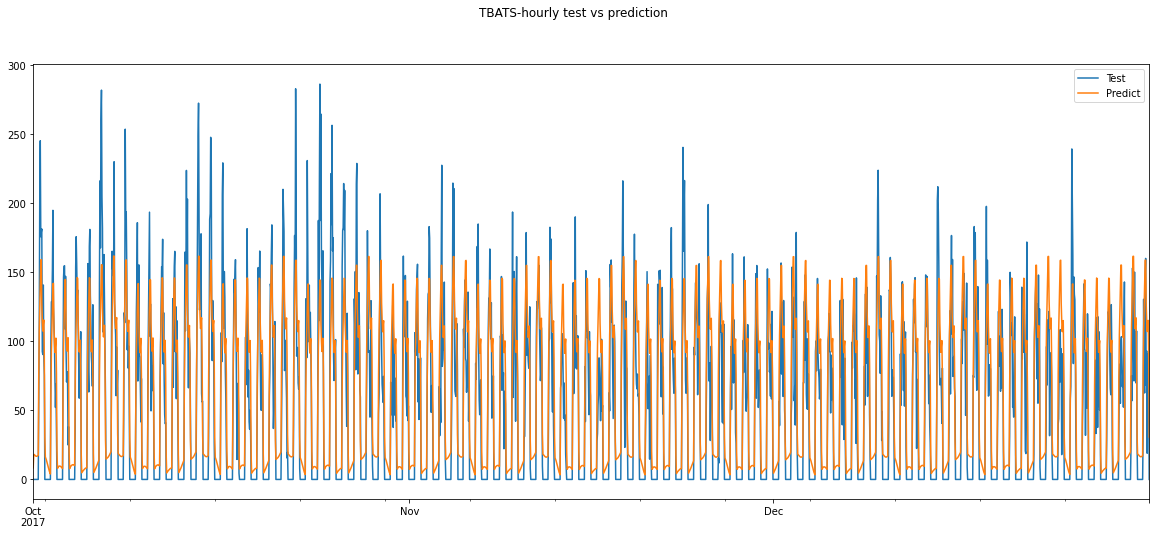

In [17]:
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(20,8))
plt.suptitle('TBATS-hourly test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS-hourly_test_prediction.png')

The 2 month forecast vs test shows the weekly periodicity more clearly.

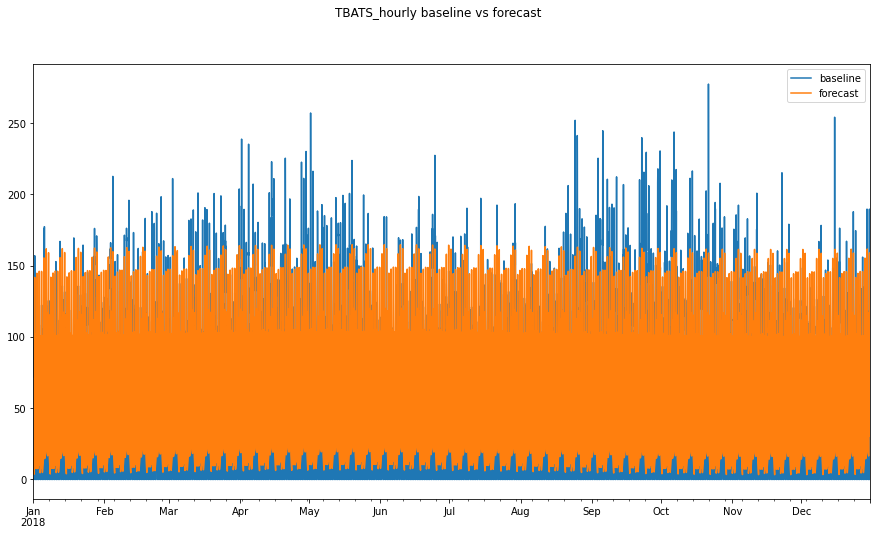

In [18]:
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':fore}).plot(figsize=(15,8))
plt.suptitle('TBATS_hourly baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_hourly_baseline_forecast.png')

Based on the plot above, there doesn't seem to be yearly seasonality involved. Let's try to view the numbers and see.

In [8]:
# let's view the prediction numbers
TBATSY = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_fore.csv')
TBATSY['date'] = pd.date_range('2018-01-01', periods=8736, freq='h')
TBATSY = TBATSY.set_index('date')
TBATSY

,fore
date,
2018-01-01 00:00:00,15.994969
2018-01-01 01:00:00,15.048023
2018-01-01 02:00:00,13.899654
2018-01-01 03:00:00,12.519188
2018-01-01 04:00:00,11.034066
...,...
2018-12-30 19:00:00,107.179106
2018-12-30 20:00:00,112.070726
2018-12-30 21:00:00,115.186091


In [9]:
monthly_sum = TBATSY.fore.groupby(TBATSY.index.month).sum()
monthly_sum

date
1     46028.343844
2     42348.316116
3     47617.236274
4     46522.055966
5     47974.013380
6     46866.112993
7     47766.565898
8     47042.627428
9     45433.257452
10    45782.594213
11    44273.168893
12    44803.262258
Name: fore, dtype: float64

In [10]:
bl_monthly = baseline.groupby(baseline.index.month).sum()
bl_monthly

1     31942.356111
2     33778.406852
3     37064.302232
4     39962.625000
5     39393.714444
6     35969.301935
7     36771.213529
8     37804.220900
9     42322.598390
10    40242.400000
11    34686.703569
12    32823.907963
Name: baseline, dtype: float64

The model failed to capture the yearly seaonality, which September should be the peak month, and it is very likely to be overestimating.

# AA with Month, DoW, HoD as exog
Using regular dummies will take too much memory, we will redo the dummies by allocating the normalized value of mentioned features. For example, if March has best hourly sales mean, assuming 100, it'll have 1 for March, and if February only had hourly sales mean of 70, it will be 0.7 for February.

In [8]:
# get the mean of wanted values from dfts24 which has the data of 2016 1/4 ~ end of 2017
month_mean = dfts24.sales.groupby(dfts24.index.month).mean()
hod_mean = dfts24.sales.groupby(dfts24.index.hour).mean()
dow_mean = dfts24.sales.groupby(dfts24.index.weekday).mean()
display(month_mean.head(3))
display(hod_mean.head(3))
display(dow_mean.head(3))

1    43.290051
2    49.654593
3    49.379943
Name: sales, dtype: float64

0    0.0
1    0.0
2    0.0
Name: sales, dtype: float64

0    46.096524
1    46.989878
2    47.333474
Name: sales, dtype: float64

In [20]:
# we will concat the baseline together with dfts24 to form 3 years of data
dfts24bl = pd.concat([dfts24.sales, baseline])
dfts24bl #it's not a dataframe

2016-01-04 00:00:00      0.000000
2016-01-04 01:00:00      0.000000
2016-01-04 02:00:00      0.000000
2016-01-04 03:00:00      0.000000
2016-01-04 04:00:00      0.000000
                          ...    
2018-12-30 19:00:00     52.335000
2018-12-30 20:00:00     76.536731
2018-12-30 21:00:00    101.972692
2018-12-30 22:00:00     75.392885
2018-12-30 23:00:00      0.000000
Freq: H, Length: 26208, dtype: float64

In [21]:
# make it to a dataframe
df3 = pd.DataFrame({
    'sales':dfts24bl
})
display(df3.info()) #check the freq make sure it's H
df3 #check n see

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26208 entries, 2016-01-04 00:00:00 to 2018-12-30 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   26208 non-null  float64
dtypes: float64(1)
memory usage: 409.5 KB


None

,sales
2016-01-04 00:00:00,0.000000
2016-01-04 01:00:00,0.000000
2016-01-04 02:00:00,0.000000
2016-01-04 03:00:00,0.000000
2016-01-04 04:00:00,0.000000
...,...
2018-12-30 19:00:00,52.335000
2018-12-30 20:00:00,76.536731
2018-12-30 21:00:00,101.972692
2018-12-30 22:00:00,75.392885


In [13]:
# prep the exog features
exog = df3.copy()
#setting the normalized values of given month/HoD/DoW based on the max of its mean
exog['month'] = exog.index.month
exog['month'].replace([i for i in range(1,13)], [month_mean[i]/month_mean.max() for i in range(1,13)], inplace=True)
exog['HoD'] = exog.index.hour
exog['HoD'].replace([i for i in range(24)], [hod_mean[i]/hod_mean.max() for i in range(24)], inplace=True)
exog['DoW'] = exog.index.weekday
exog['DoW'].replace([i for i in range(7)], [dow_mean[i]/dow_mean.max() for i in range(7)], inplace=True)
exog = exog.drop(columns=['sales'])
display(exog.head(3))
display(exog.tail(3))

,month,HoD,DoW
2016-01-04 00:00:00,0.744825,0.0,0.798968
2016-01-04 01:00:00,0.744825,0.0,0.798968
2016-01-04 02:00:00,0.744825,0.0,0.798968


,month,HoD,DoW
2018-12-30 21:00:00,0.7825,0.680111,0.958829
2018-12-30 22:00:00,0.7825,0.493783,0.958829
2018-12-30 23:00:00,0.7825,0.092629,0.958829


In [14]:
#set the train & test data, ran out of memery when train=1 year and 8months, let's try 1 year and 6 months or 546days
train = df3.sales[:(24*546)]
test = df3.sales[len(train):]
#set the exog
exog_to_train = exog.iloc[:len(train)]
exog_to_test = exog.iloc[len(train):] 

In [15]:
#double check the start/end times
print('train ends at', train.tail(1))
print('test starts at', test.head(1))
print('test ends at', test.tail(1))

train ends at 2017-07-02 23:00:00    0.0
Freq: H, Name: sales, dtype: float64
test starts at 2017-07-03    0.0
Freq: H, Name: sales, dtype: float64
test ends at 2018-12-30 23:00:00    0.0
Freq: H, Name: sales, dtype: float64


In [19]:
# run the auto_arima
model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

In [20]:
# forecast
forecast = model.predict(n_periods=(len(test)), exogenous=exog_to_test)
pred = forecast[:24*182] #half of 364 is 182 days
fore = forecast[24*182:]

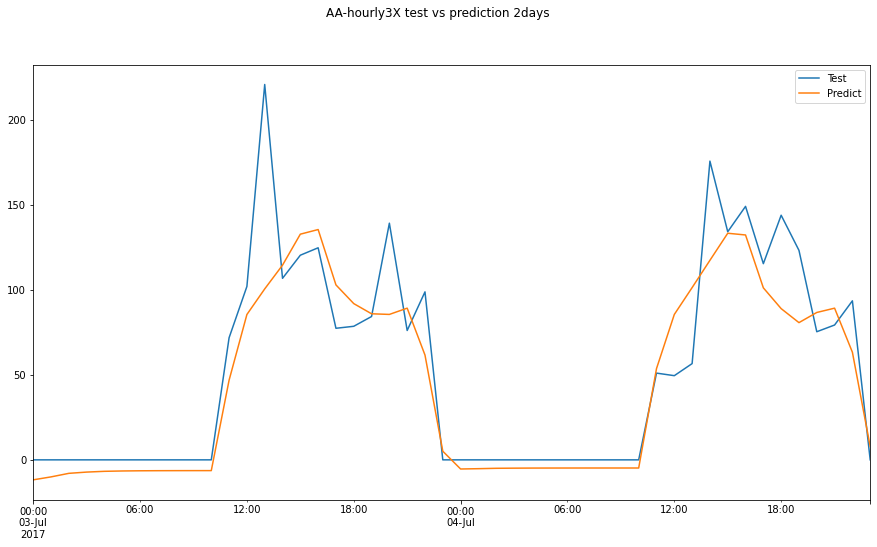

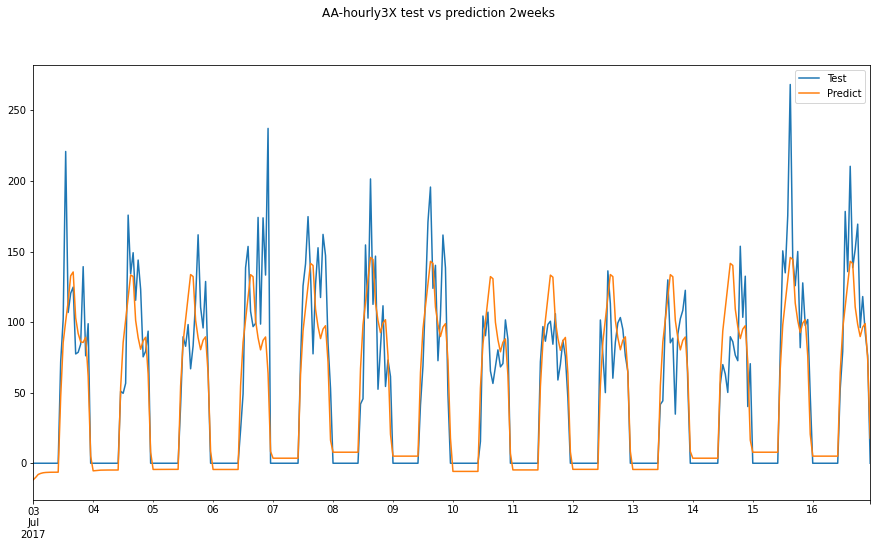

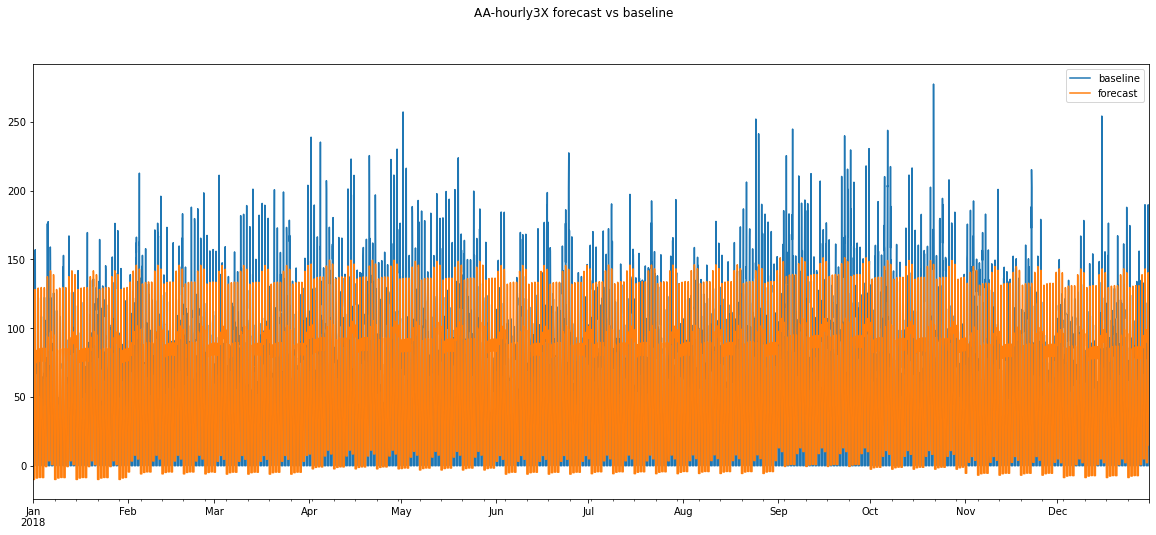

In [22]:
#get the plot of test vs pred first's 48 hours
pd.DataFrame({'test':test[:48],'pred':pred[:48]}).plot(figsize=(15,8))
plt.suptitle('AA-hourly3X test vs prediction 2days')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourly3X test vs prediction 2days.png')
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:24*14],'pred':pred[:24*14]}).plot(figsize=(15,8))
plt.suptitle('AA-hourly3X test vs prediction 2weeks')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourly3X test vs prediction 2weeks.png')
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'prediction':fore}).plot(figsize=(20,8))
plt.suptitle('AA-hourly3X forecast vs baseline')
plt.legend(["baseline", "forecast"])
plt.savefig('AA-hourly3X forecast vs baseline.png')

From the plots above, we can see that all three seasonality/periodicity exisits. But the predictions aren't too great. Let's record the forecasts and find its metrics scores.

In [26]:
# save the info and metric scores
AA_hourly3X_df = pd.DataFrame({
    'model': 'AA-3X',
    'forecast':forecast,
    'MSE': mean_squared_error(test[:182*24],pred),
    'MAE': mean_absolute_error(test[:182*24],pred),
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore),
})
AA_hourly3X_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourly3X.csv',
                      index=False)

In [16]:
# load the file incase we need to rerun
AA_hourly3X_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourly3X.csv')
AA_hourly3X_df.head(1)

,model,forecast,MSE,MAE,ForeMSE,ForeMAE
0,AA-3X,-11.758169,865.058499,18.589293,427.275663,13.892706


# AA with ranked order exog features

In [17]:
# let's take a look at each month's hourly mean, and divide them into 3 groups by using quantile
mbm = dfts24.sales.groupby(dfts24.index.month).mean()
display(mbm.quantile(0.67))
display(mbm.quantile(0.33))
mbm.sort_values()

51.59849250819871

49.37606950231944

1     43.290051
12    45.479782
11    48.206067
6     49.369475
3     49.379943
2     49.654593
7     49.880919
8     50.127960
5     54.102372
10    55.016909
4     55.388986
9     58.121121
Name: sales, dtype: float64

In [18]:
# make new lists naming monthrank 1~3 based on month's mean hourly sales being most influential
monthrank1 = [1, 12, 11, 6] #1 means lower sales
monthrank2 = [3, 2, 7, 8]
monthrank3 = [5, 10, 4, 9] #3 is higher number thus better

In [19]:
# do similar thing for day of week, weekends is usually busier and so it's either busy day or slow day
dowm = dfts24.sales.groupby(dfts24.index.weekday).mean()
dowm.sort_values() #the result is obvious, weekends have better sales we'll call this weekend dummie instead.

0    46.096524
1    46.989878
3    47.266771
2    47.333474
4    54.075524
6    55.319767
5    57.695105
Name: sales, dtype: float64

In [20]:
# let's take a look at hourly mean and decide what to do
hourmean = dfts24.sales.groupby(dfts24.index.hour).mean()
hourmean.sort_values()

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
23     12.935760
11     59.810349
22     68.957721
19     85.734230
12     91.237229
20     92.557033
18     94.341186
21     94.978774
17    106.871460
13    107.321677
14    123.814565
16    138.166633
15    139.651818
Name: sales, dtype: float64

In [21]:
# make a new dataframe and change the values based on $20 per rank
hourly = hourmean.copy()
for i in range(24):
    j = int(round(hourly[i]/20,0))
    hourly[i] = j
hourly.sort_values()

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
23    1.0
22    3.0
11    3.0
19    4.0
12    5.0
13    5.0
17    5.0
18    5.0
20    5.0
21    5.0
14    6.0
15    7.0
16    7.0
Name: sales, dtype: float64

In [22]:
hourly = [i for i in range(11)]
hourly1 = [23]
hourly3 = [11,22]
hourly4 = [19]
hourly5 = [12,13,17,18,20,21]
hourly6 = [14]
hourly7 = [15,16]

In [23]:
# redo the exog
exog = df3.copy()
# set the month exog
exog['month'] = exog.index.month
exog['month'].replace(monthrank1, 1, inplace=True)
exog['month'].replace(monthrank2, 2, inplace=True)
exog['month'].replace(monthrank3, 3, inplace=True)
# set the weekend exog
exog['weekend'] = exog.index.weekday
exog['weekend'].replace([1,2,3], 0, inplace=True)
exog['weekend'].replace([4,5,6], 1, inplace=True)
# set the HoD exog
exog['HoD'] = exog.index.hour
exog['HoD'].replace(hourly, 0, inplace=True)
exog['HoD'].replace(hourly1, 1, inplace=True)
exog['HoD'].replace(hourly3, 3, inplace=True)
exog['HoD'].replace(hourly4, 4, inplace=True)
exog['HoD'].replace(hourly5, 5, inplace=True)
exog['HoD'].replace(hourly6, 6, inplace=True)
exog['HoD'].replace(hourly7, 7, inplace=True)
# drop the sales columns
exog=exog.drop(columns=['sales'])
exog.tail()

,month,weekend,HoD
2018-12-30 19:00:00,1,1,4
2018-12-30 20:00:00,1,1,5
2018-12-30 21:00:00,1,1,5
2018-12-30 22:00:00,1,1,3
2018-12-30 23:00:00,1,1,1


C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

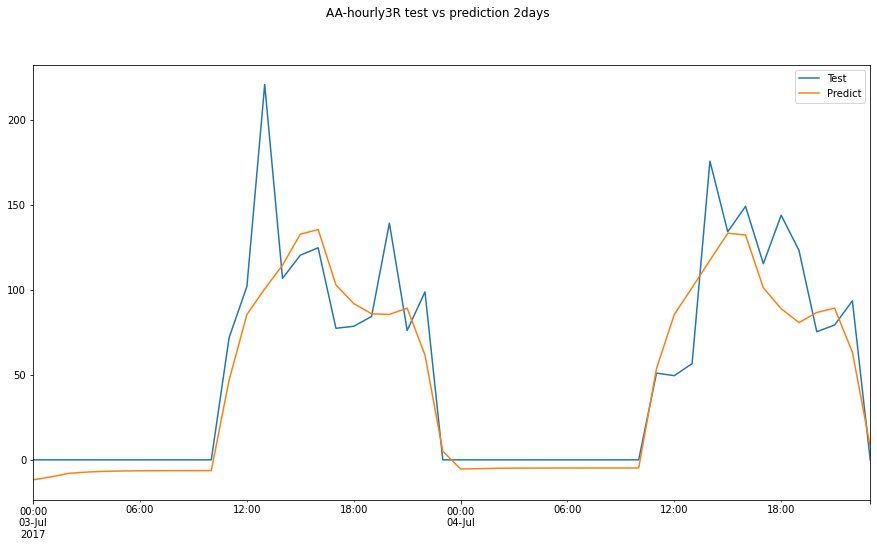

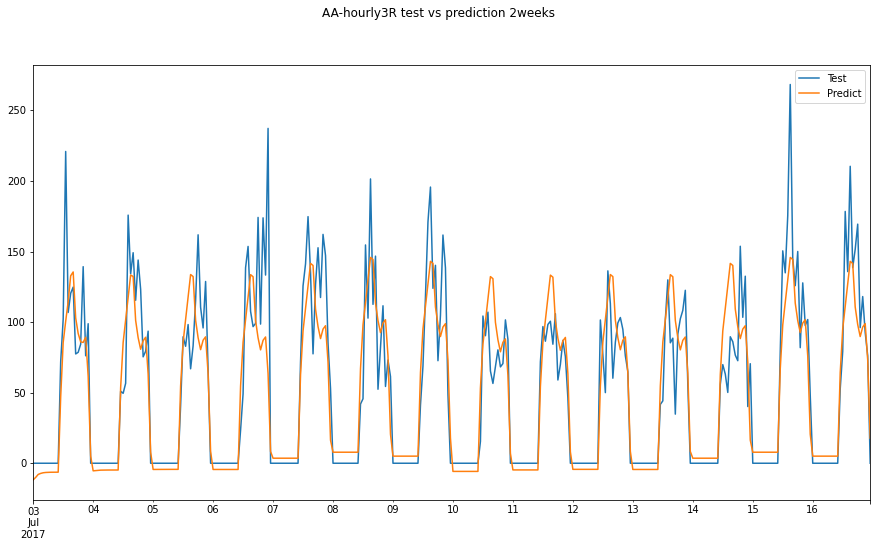

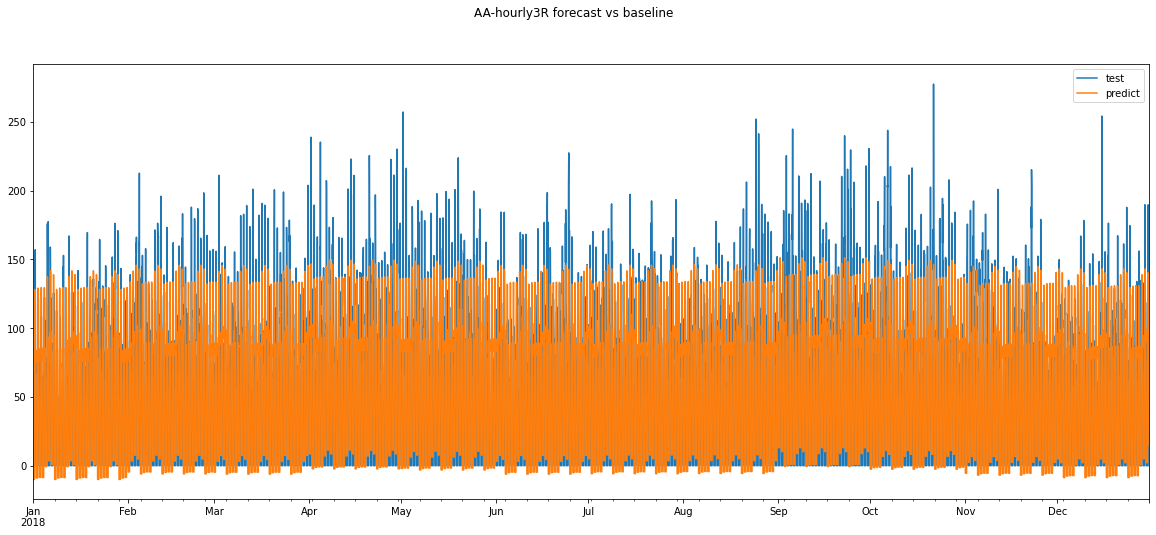

In [35]:
# run the auto_arima
model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
# forecast
forecast = model.predict(n_periods=(len(test)), exogenous=exog_to_test)
pred = forecast[:24*182] #half year is 182 days
fore = forecast[24*182:] #the rest
#get the plot of test vs pred first's 48 hours
pd.DataFrame({'test':test[:(24*2)],'pred':pred[:(24*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourly3R test vs prediction 2days')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourly3R test vs prediction 2days.png')
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourly3R test vs prediction 2weeks')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourly3R test vs prediction 2weeks.png')
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':fore}).plot(figsize=(20,8))
plt.suptitle('AA-hourly3R forecast vs baseline')
plt.legend(["test", "predict"])
plt.savefig('AA-hourly3R forecast vs baseline.png')

In [45]:
# save the info
AA_hourly3R_df = pd.DataFrame({
    'model': 'AA-3R',
    'forecast':forecast,
    'MSE': mean_squared_error(test[:182*24],pred),
    'MAE': mean_absolute_error(test[:182*24],pred),
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore),
})
AA_hourly3R_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourly3R.csv',
                      index=False)

In [24]:
AA_hourly3R_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourly3R.csv')
AA_hourly3R_df.head(1) #it seems to be the same as 3X

,model,forecast,MSE,MAE,ForeMSE,ForeMAE
0,AA-3R,-11.758169,865.058499,18.589293,427.275663,13.892706


In [25]:
AA_hourly3X_df.describe() #check forecast info and see if it matches with 3R

,forecast,MSE,MAE,ForeMSE,ForeMAE
count,13104.000000,1.310400e+04,13104.000000,1.310400e+04,1.310400e+04
mean,50.285745,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
std,52.120793,1.136912e-13,0.000000,1.136912e-13,3.552849e-15
min,-11.758169,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
25%,0.523506,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
50%,36.379095,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
75%,97.120791,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
max,151.104741,8.650585e+02,18.589293,4.272757e+02,1.389271e+01


In [26]:
AA_hourly3R_df.describe() #it's the same as 3X

,forecast,MSE,MAE,ForeMSE,ForeMAE
count,13104.000000,1.310400e+04,13104.000000,1.310400e+04,1.310400e+04
mean,50.285745,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
std,52.120793,1.136912e-13,0.000000,1.136912e-13,3.552849e-15
min,-11.758169,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
25%,0.523506,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
50%,36.379095,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
75%,97.120791,8.650585e+02,18.589293,4.272757e+02,1.389271e+01
max,151.104741,8.650585e+02,18.589293,4.272757e+02,1.389271e+01


In [27]:
# let's try to decompose the seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
series = df3
result = seasonal_decompose(series, model='additive') #we have 0s, so can't use multiplicative model
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

2016-01-04 00:00:00   NaN
2016-01-04 01:00:00   NaN
2016-01-04 02:00:00   NaN
2016-01-04 03:00:00   NaN
2016-01-04 04:00:00   NaN
                       ..
2018-12-30 19:00:00   NaN
2018-12-30 20:00:00   NaN
2018-12-30 21:00:00   NaN
2018-12-30 22:00:00   NaN
2018-12-30 23:00:00   NaN
Freq: H, Name: trend, Length: 26208, dtype: float64
2016-01-04 00:00:00   -50.680544
2016-01-04 01:00:00   -50.682516
2016-01-04 02:00:00   -50.684110
2016-01-04 03:00:00   -50.687555
2016-01-04 04:00:00   -50.689974
                         ...    
2018-12-30 19:00:00    35.086318
2018-12-30 20:00:00    41.893191
2018-12-30 21:00:00    44.293838
2018-12-30 22:00:00    18.273296
2018-12-30 23:00:00   -37.731266
Freq: H, Name: seasonal, Length: 26208, dtype: float64
2016-01-04 00:00:00   NaN
2016-01-04 01:00:00   NaN
2016-01-04 02:00:00   NaN
2016-01-04 03:00:00   NaN
2016-01-04 04:00:00   NaN
                       ..
2018-12-30 19:00:00   NaN
2018-12-30 20:00:00   NaN
2018-12-30 21:00:00   NaN
2018-12-30

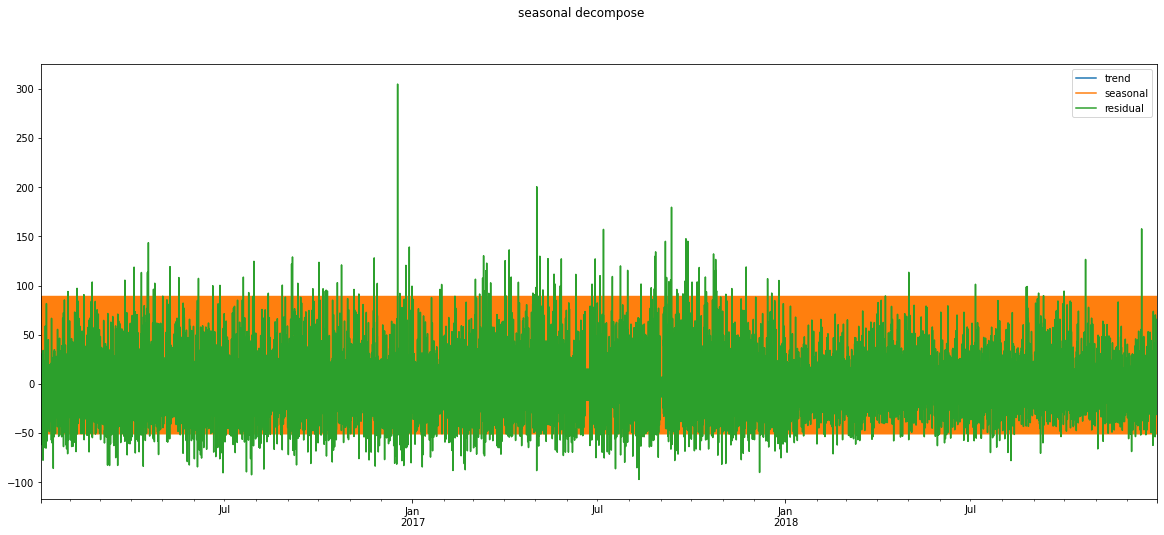

In [28]:
# view them in plots for easier observations
pd.DataFrame({'trend':result.trend, 'seasonal':result.seasonal, 'residual':result.resid,}).plot(figsize=(20,8))
plt.suptitle('seasonal decompose')
plt.legend(["trend", "seasonal","residual"])
plt.show()

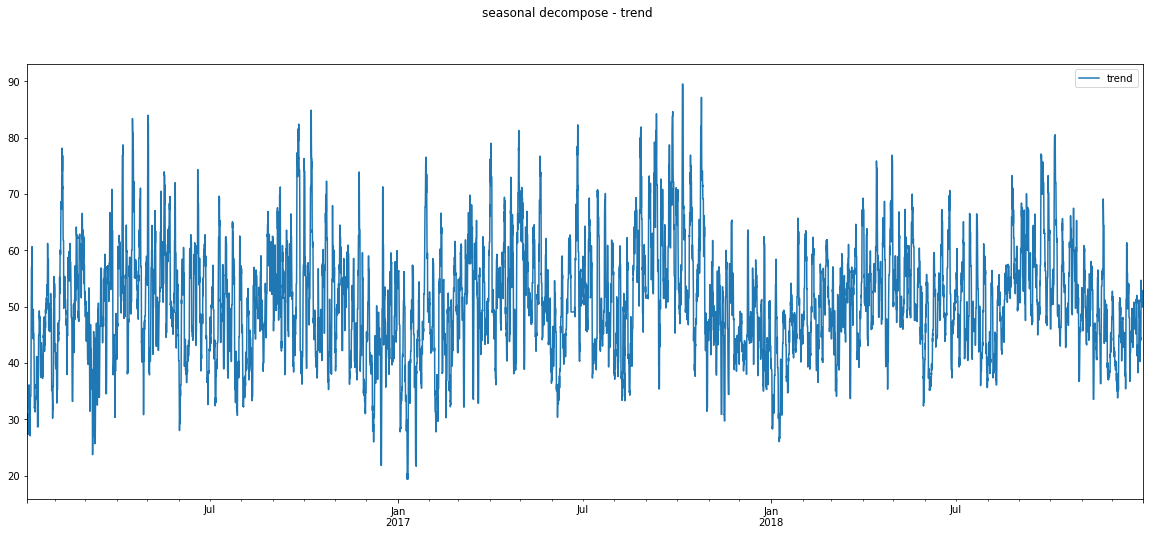

In [29]:
# trend was covered, so let's view it by itself
pd.DataFrame({'trend':result.trend}).plot(figsize=(20,8))
plt.suptitle('seasonal decompose - trend')
plt.legend(["trend"])
plt.show()

In [30]:
# let's make a dataframe with 2016to end of 2017 deseasonalized
dsdf = df3.sales - result.seasonal
dsdf = pd.DataFrame(dsdf, columns=['sales'])
dsdf

,sales
2016-01-04 00:00:00,50.680544
2016-01-04 01:00:00,50.682516
2016-01-04 02:00:00,50.684110
2016-01-04 03:00:00,50.687555
2016-01-04 04:00:00,50.689974
...,...
2018-12-30 19:00:00,17.248682
2018-12-30 20:00:00,34.643540
2018-12-30 21:00:00,57.678854
2018-12-30 22:00:00,57.119588


In [34]:
# let's tset the train and test data
train = dsdf.sales[:24*(364+182)] # 2016~2017 leave the last 1/2 year for test (not enough memory)
test = df3.sales[24*(364+182):] # we will need to add the seasonal before we test
display(train.tail(1)) #check the dates
display(test.head(1))
test.tail(1)

2017-07-02 23:00:00    37.731266
Freq: H, Name: sales, dtype: float64

2017-07-03    0.0
Freq: H, Name: sales, dtype: float64

2018-12-30 23:00:00    0.0
Freq: H, Name: sales, dtype: float64

# TBATS with deseasoned data

In [20]:
# since auto arima is having error, let's try TBATS without the 24 hourly seasonality but with weekly and yearly.
model = TBATS(seasonal_periods=(168, 8736)).fit(train)

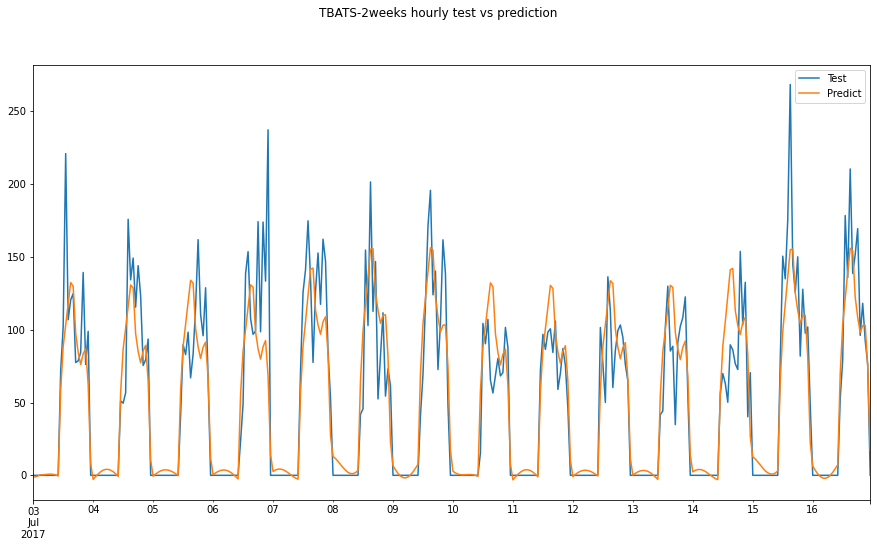

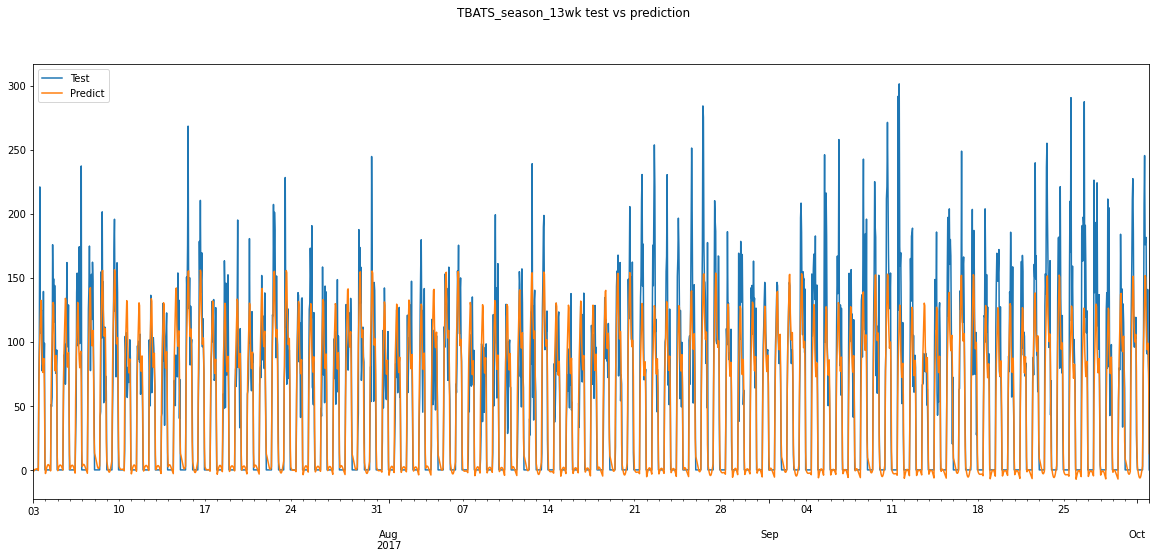

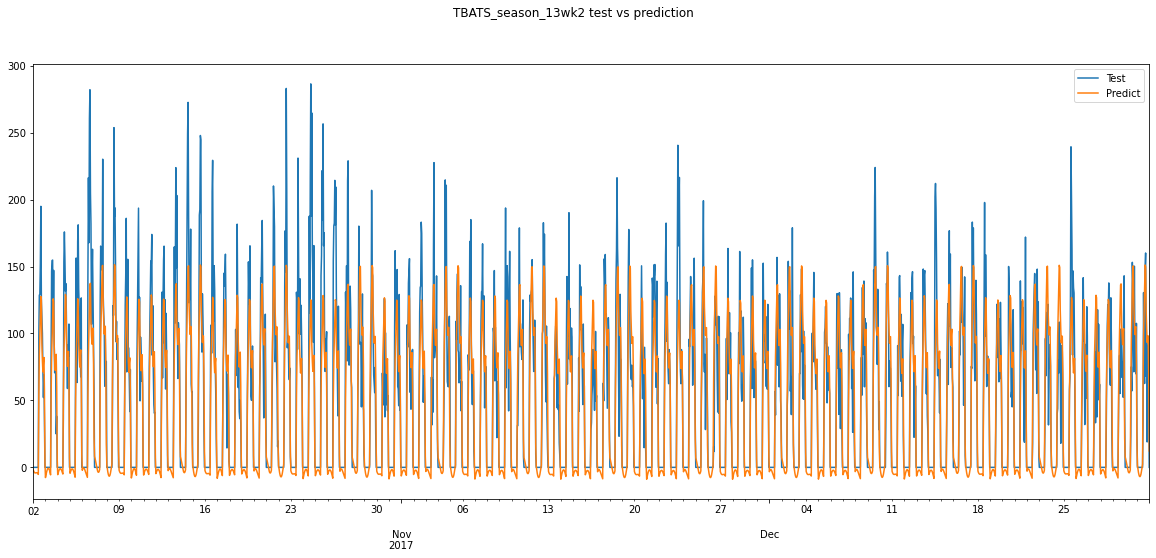

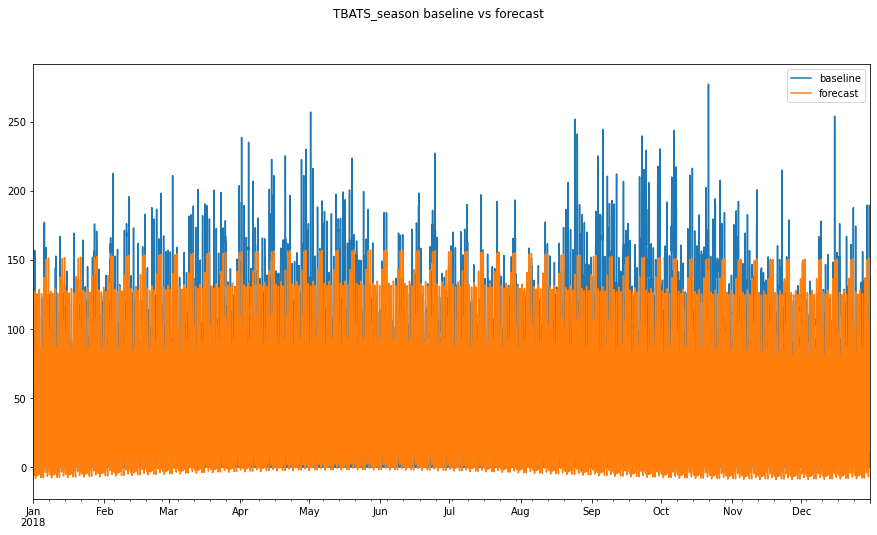

In [28]:
# forecasts
forecast = model.forecast(steps=(len(train))) #length of train is 1 and 1/2 years
#add the daily seasonality back to the forecast
forecast_season = forecast + result.seasonal[24*182*3:]
# get the pred and fore
pred = forecast_season[:24*182]
fore = forecast_season[24*182:]
#create a dataframe to record and save the scores and forecast as csv
TBATS_season_score = pd.DataFrame({
    'forecast_season': forecast_season,
    'model':'TBATS-hourly-season',
    'MSE':mean_squared_error(test[:24*182],pred),
    'MAE':mean_absolute_error(test[:24*182],pred),
    'AIC':model.aic,
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore)
})
TBATS_season_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS_season_score.csv',
                index=False)
#view the plot of test vs pred first 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('TBATS-2weeks hourly test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS-2weeks hourly test vs prediction.png')
#view the plot of test vs pred 13weeks
pd.DataFrame({'test':test[:24*7*13],'pred':pred[:24*7*13]}).plot(figsize=(20,8))
plt.suptitle('TBATS_season_13wk test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_season_13wk_test_prediction.png')
#view the plot of test vs pred 13weeks 2nd half
pd.DataFrame({'test':test[24*7*13:24*7*13*2],'pred':pred[24*7*13:]}).plot(figsize=(20,8))
plt.suptitle('TBATS_season_13wk2 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_season_13wk2_test_prediction.png')
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':fore}).plot(figsize=(15,8))
plt.suptitle('TBATS_season baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_season_baseline_forecast.png')

The daily and weekly periodicity looks great, but the yearly seasonality is off. Apr, May, Sep, Oct should have been the peak.

In [30]:
# save the info
TBATS_hourly_season_df = pd.DataFrame({
    'model': 'TBATS_hourly_season',
    'forecast_season':forecast_season,
    'MSE': mean_squared_error(test[:len(pred)],pred),
    'MAE': mean_absolute_error(test[:len(pred)],pred),
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore),
})
TBATS_hourly_season_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS_hourly_season_df.csv',
                      index=False)

In [32]:
TBATS_hourly_season_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS_hourly_season_df.csv')
TBATS_hourly_season_df.head(1)

,model,forecast_season,MSE,MAE,ForeMSE,ForeMAE
0,TBATS_hourly_season,-1.236315,886.769417,17.873756,417.536723,12.899407


# Auto Arima with Month and DoW as exog using deseasoned data

In [33]:
# redo the exog, since the daily seasonality has been deseasoned, we don't need HoD as a feature
exog = dsdf.copy()
# set the month exog
exog['month'] = exog.index.month
exog['month'].replace(monthrank1, 1, inplace=True)
exog['month'].replace(monthrank2, 2, inplace=True)
exog['month'].replace(monthrank3, 3, inplace=True)
# set the weekend exog
exog['weekend'] = exog.index.weekday
exog['weekend'].replace([1,2,3], 0, inplace=True)
exog['weekend'].replace([4,5,6], 1, inplace=True)
# drop the sales columns
exog=exog.drop(columns=['sales'])
exog.tail()

,month,weekend
2018-12-30 19:00:00,1,1
2018-12-30 20:00:00,1,1
2018-12-30 21:00:00,1,1
2018-12-30 22:00:00,1,1
2018-12-30 23:00:00,1,1


In [35]:
#set the train & test data, ran out of memory, so 2016 unseasoned for train 2017 for test
train = dsdf.sales[:24*(364)]
test = dfts2017.sales
#set the exog
exog_to_train = exog.iloc[:len(train)]
exog_to_test = exog.iloc[len(train):] 

In [36]:
# run the auto_arima
model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

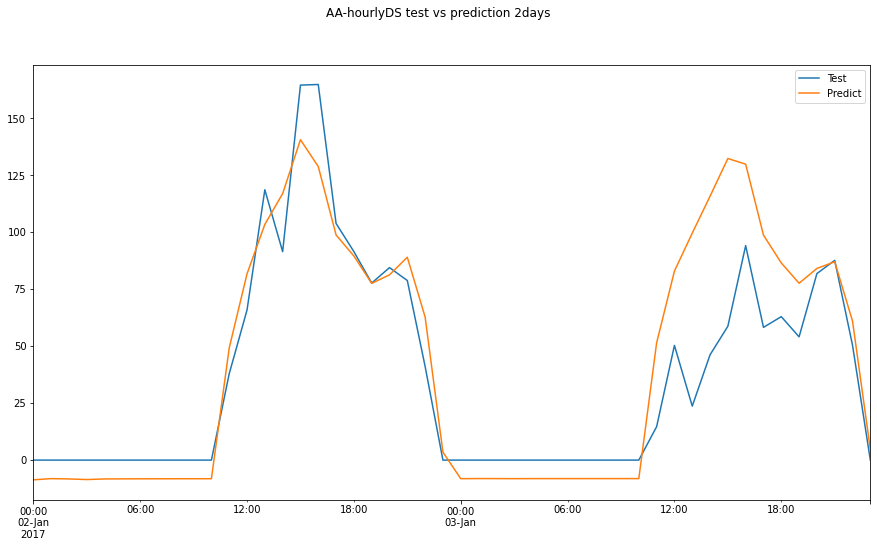

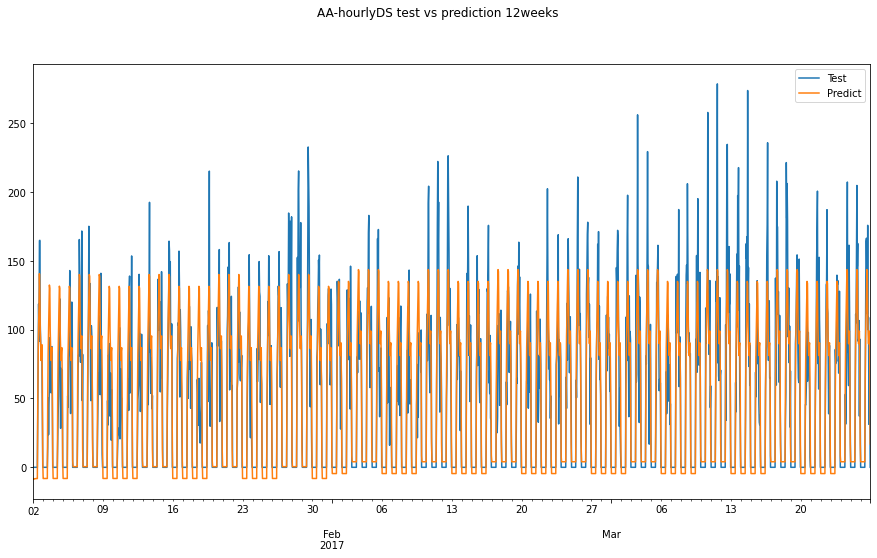

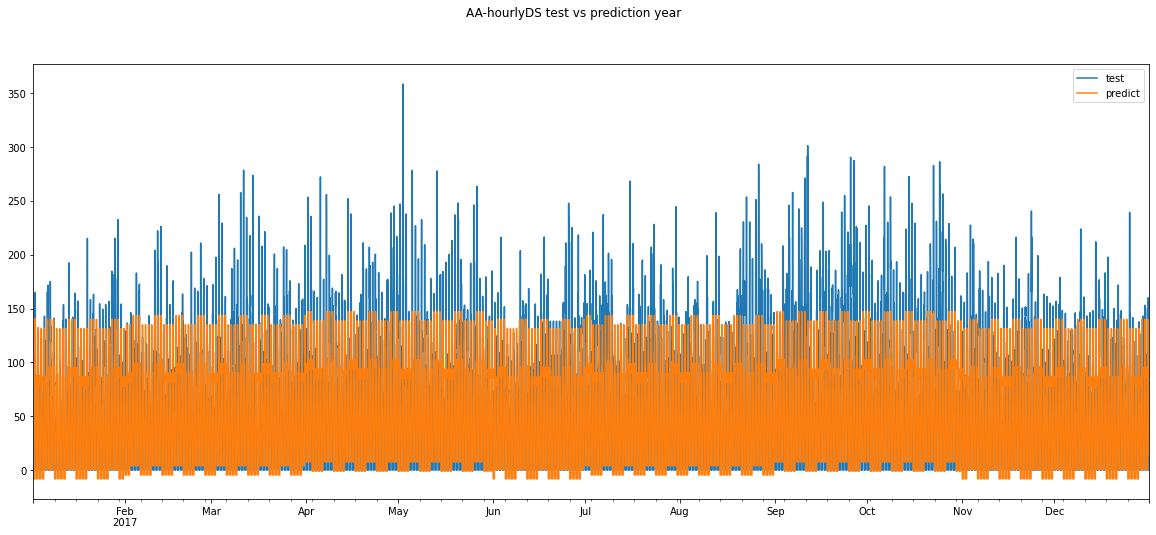

In [43]:
# forecast
forecast = model.predict(n_periods=(24*364), exogenous=exog_to_test[:24*364])
# add the seasonality back
pred = forecast + result.seasonal[24*364:24*364*2]
#get the plot of test vs pred first's 48 hours
pd.DataFrame({'test':test[:(24*2)],'pred':pred[:(24*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyDS test vs prediction 2days')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyDS test vs prediction 2days.png')
#get the plot of test vs pred first's 12 weeks
pd.DataFrame({'test':test[:(24*7*12)],'pred':pred[:(24*7*12)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyDS test vs prediction 12weeks')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyDS test vs prediction 12weeks.png')
#view the whole year
pd.DataFrame({'test':test, 'pred':pred}).plot(figsize=(20,8))
plt.suptitle('AA-hourlyDS test vs prediction year')
plt.legend(["test", "predict"])
plt.savefig('AA-hourlyDS test vs prediction year.png')

The model is able to capture all 3 seasonalities.

In [44]:
# save the info
AA_hourlyDS_df = pd.DataFrame({
    'model': 'AA_hourly_DS',
    'pred':pred,
    'MSE': mean_squared_error(test[:len(pred)],pred),
    'MAE': mean_absolute_error(test[:len(pred)],pred),
})
AA_hourlyDS_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourlyDS.csv',
                      index=False)

In [29]:
AA_hourlyDS_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourlyDS.csv')
AA_hourlyDS_df['date'] = pd.date_range('2017-01-02', periods=8736, freq='h')
AA_hourlyDS_df = AA_hourlyDS_df.set_index('date')
AA_hourlyDS_df.head(1)

,model,pred,MSE,MAE
date,,,,
2017-01-02,AA_hourly_DS,-8.664219,790.17725,17.524432


In [31]:
# load the AA houlry 3exog and compare the metric scores
AA_hourly3X_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_hourly3X.csv')
AA_hourly3X_df.head(1)

,model,forecast,MSE,MAE,ForeMSE,ForeMAE
0,AA-3X,-11.758169,865.058499,18.589293,427.275663,13.892706


AA_hourlyDS has its test date from 2017-01-02 to end of 2017, while AA-3X had laster half of 2017 as test, and 2018 as base line (ForeMSE and ForeMAE calculated this way). So if we are to compare one year of data testing, AA-3X has much better results.